Validation Issues Detected:
Student overlap detected.
Venue overlap detected.
Invalid day or time slots detected.
Data completeness issue: missing values detected.


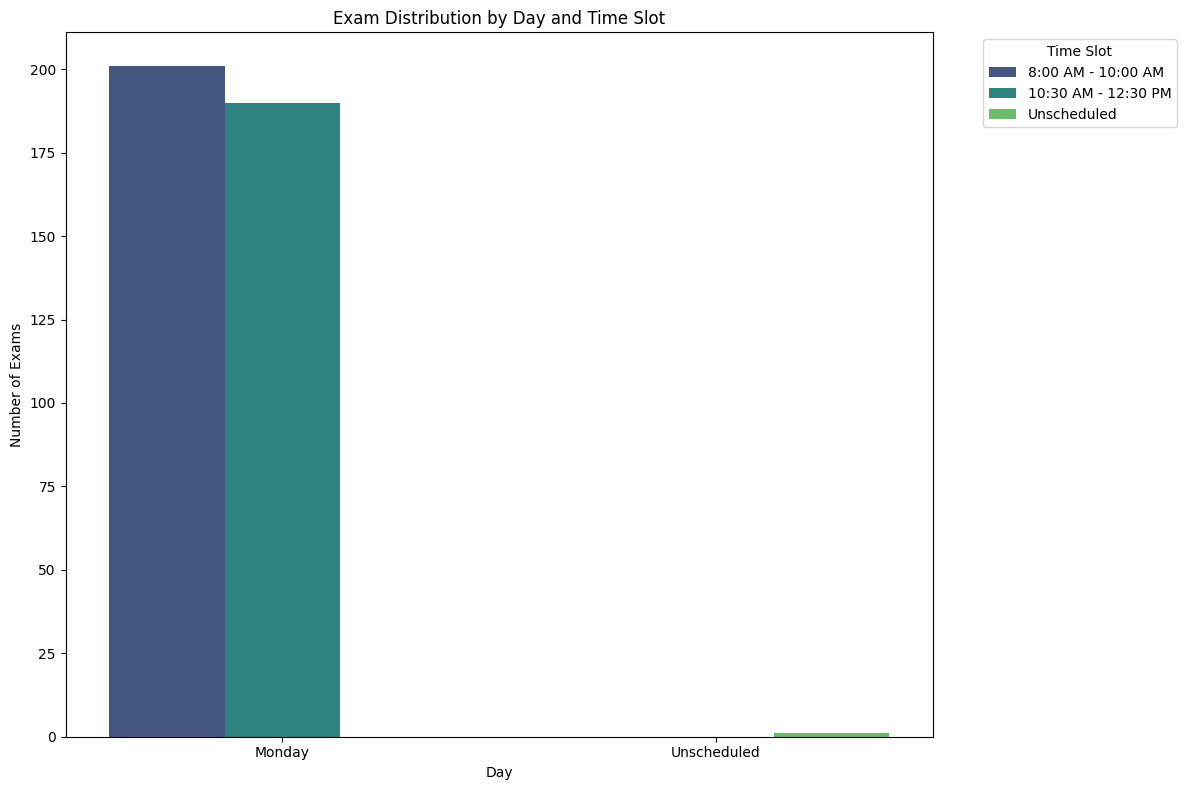

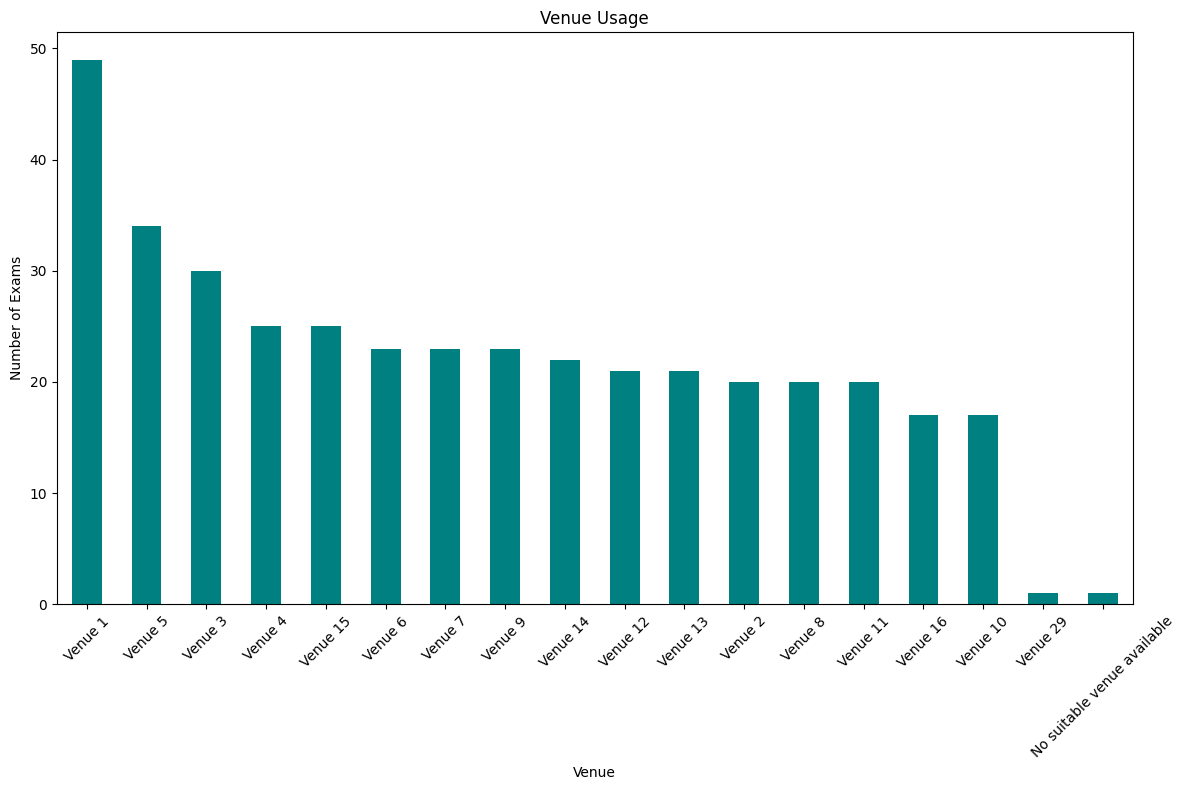

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load JSON file
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(data['timetable'])

# Visualization and Validation
def validate_timetable(df):
    issues = []

    # Check for overlapping schedules (Students, Invigilators, Venues)
    overlaps = df.groupby(['day', 'time_slot'])
    student_overlaps = overlaps['venue'].transform('count') > 1
    venue_overlaps = overlaps['venue'].transform('nunique') < overlaps['venue'].transform('count')

    if student_overlaps.any():
        issues.append("Student overlap detected.")
    if venue_overlaps.any():
        issues.append("Venue overlap detected.")

    # Venue capacity issues
    if 'venue_capacity' in df.columns:
        df['venue_capacity_issue'] = df['students'] > df['venue_capacity']
        capacity_issues = df[df['venue_capacity_issue']]
        if not capacity_issues.empty:
            issues.append("Some venues exceed their capacity:")
            for _, row in capacity_issues.iterrows():
                issues.append(f"- {row['course_name']} exceeds capacity at {row['venue']}.")

    # Day and Time Slot Validity
    invalid_slots = df[~df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])]
    if not invalid_slots.empty:
        issues.append("Invalid day or time slots detected.")

    # Fairness of Invigilator Allocation
    invigilator_counts = df.explode('assigned_invigilators')['assigned_invigilators'].value_counts()
    fairness_threshold = invigilator_counts.std()
    if fairness_threshold > 5:  # Arbitrary threshold for fairness
        issues.append("Invigilator allocation fairness issue detected.")

    # Combined Course Scheduling
    combined_courses = df[df['course_name'].str.contains('Combined', case=False, na=False)]
    if not combined_courses.empty:
        issues.append("Combined courses need careful scheduling checks.")

    # Unscheduled Exams
    unscheduled_exams = df[df['venue'].isnull() | df['time_slot'].isnull()]
    if not unscheduled_exams.empty:
        issues.append("Unscheduled exams detected.")

    # Data Completeness
    if df.isnull().any().any():
        issues.append("Data completeness issue: missing values detected.")

    # Error Handling
    if df.duplicated(subset=['course_code', 'day', 'time_slot']).any():
        issues.append("Duplicate course scheduling detected.")

    return issues

# Visualization
def visualize_timetable(df):
    plt.figure(figsize=(12, 8))
    sns.countplot(data=df, x='day', hue='time_slot', palette='viridis')
    plt.title('Exam Distribution by Day and Time Slot')
    plt.xlabel('Day')
    plt.ylabel('Number of Exams')
    plt.legend(title='Time Slot', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    venue_usage = df['venue'].value_counts()
    venue_usage.plot(kind='bar', color='teal')
    plt.title('Venue Usage')
    plt.xlabel('Venue')
    plt.ylabel('Number of Exams')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main Function
def main():
    file_path = 'exam_timetable.json'  # Replace with your file path
    timetable_df = load_json(file_path)

    # Validate Timetable
    issues = validate_timetable(timetable_df)
    if issues:
        print("Validation Issues Detected:")
        for issue in issues:
            print(issue)
    else:
        print("No validation issues detected.")

    # Visualize Timetable
    visualize_timetable(timetable_df)

if __name__ == "__main__":
    main()
